In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
from os.path import expanduser

from imagemks.rw import rwformat

def vis(A):
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.imshow(A, cmap='gray')
    plt.show(fig)

In [2]:
# Importing general libraries
import numpy as np
import scipy.ndimage as ndi
import pandas as pd

# Importing specific functions
from skimage.morphology import remove_small_objects, watershed
from skimage.feature import corner_peaks
from skimage.segmentation import relabel_sequential
from skimage.measure import regionprops
from skimage.color import label2rgb

# Importing ImageMKS functions
from imagemks.filters import fftgauss, local_avg
from imagemks.structures import donut
from imagemks.masking import maskfourier
from imagemks.visualization import make_boundary_image
from imagemks.workflows import visualize_fluor_cells, default_parameters

In [3]:
imgNum = 5

zoompath = expanduser('~/Projects/Cells/Cells_Data/Cell_Experimental_Data.csv')
readPath = expanduser('~/Projects/Cells/Cells_Images_Original/')

zoomLev = pd.read_csv(zoompath).loc[(imgNum-1),'MagnRatio']

p = default_parameters('muscle')

smooth_size = p['smooth_size']
intensity_curve=p['intensity_curve']
short_th_radius=p['short_th_radius']
long_th_radius=p['long_th_radius']
min_frequency_to_remove=p['min_frequency_to_remove']
max_frequency_to_remove=p['max_frequency_to_remove']
max_size_of_small_objects_to_remove=p['max_size_of_small_objects_to_remove']
power_adjust=p['power_adjust']
peak_min_distance=p['peak_min_distance']
size_after_watershed_to_remove=p['size_after_watershed_to_remove']
cyto_local_avg_size=p['cyto_local_avg_size']

# Cells - Loading Data

In [106]:
import matplotlib.image as mpimg
import segmentation_toolset as sgmt

Nc_in = mpimg.imread(readPath + 'b' + str(imgNum) + '.tif')
Cc_in = mpimg.imread(readPath + 'g' + str(imgNum) + '.tif')

Nc = np.sum(Nc_in, axis=2)
Nc = ( 255*(( Nc-np.amin(Nc)) / np.ptp(Nc)) )

Cc = np.sum(Cc_in, axis=2)
Cc = ( 255*(( Cc-np.amin(Cc)) / np.ptp(Cc)) )

# Step 1: smoothing intensity values and smoothing out peaks
Nc = sgmt.gBlur(Nc, smooth_size)

# Step 2: contrast enhancement by scaling intensities (from 0-1) on a curve
########  many other methods can be implemented for this step which could benefit the segmentation
Nc = np.power(Nc/np.amax(Nc), intensity_curve)

# ImageMKS - Loading Data

In [107]:
nucs_loader = rwformat(readPath, prefix='b', ftype='.tif')
cyto_loader = rwformat(readPath, prefix='g', ftype='.tif')

Ni = nucs_loader[imgNum]
Ci = cyto_loader[imgNum]

Ni = np.sum(np.array(Ni), axis=2)
Ni = ( (( Ni-np.amin(Ni)) / np.ptp(Ni)) )

Ci = np.sum(np.array(Ci), axis=2)
Ci = ( (( Ci-np.amin(Ci)) / np.ptp(Ci)) )

# Step 1: smoothing intensity values and smoothing out peaks
Ni = fftgauss(Ni, smooth_size, pad_type='edge')

# Step 2: contrast enhancement by scaling intensities (from 0-1) on a curve
########  many other methods can be implemented for this step which could benefit the segmentation
Ni = np.power(Ni/np.amax(Ni), intensity_curve)

In [108]:
np.allclose(Nc, Ni)

False

In [109]:
print(np.amax(Nc), np.amin(Nc), np.ptp(Nc))
print(np.amax(Ni), np.amin(Ni), np.ptp(Ni))
print(np.amax(Nc-Ni), np.amin(Nc-Ni), np.ptp(Nc-Ni))

1.0 6.714269953384952e-05 0.9999328573004661
1.0 9.795194230343886e-05 0.9999020480576966
0.07558831395944093 -0.05521115375945257 0.1307994677188935


In [98]:
# Reason that they are not the same is shown here: the kernels used for smoothing are not identical. 
# The ImageMKS kernel is more accurate as it uses the actual gaussian equation. The original equation
# uses the cross product of two 1d gaussians... not a valid approach.

s = Nc.shape
sigma = smooth_size

y = s[0]
ys = np.linspace(-y/2, y/2, y)
x = s[1]
xs = np.linspace(-x/2, x/2, x)

# Making the 2D gaussian kernel by taking two normDF in x and y and taking the outer product
yPDF = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-ys**(2)/(sigma**2))
xPDF = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-xs**(2)/(sigma**2))
kernel = np.outer(yPDF,xPDF)

print(np.amin(kernel), np.amax(kernel), np.ptp(kernel), np.sum(kernel))

from imagemks.structures import gauss

kernel = gauss(sigma=smooth_size, theta=0, size=Nc.shape, centered=True)

print(np.amin(kernel), np.amax(kernel), np.ptp(kernel), np.sum(kernel))

0.0 0.016727388529792258 0.016727388529792258 0.4995443725585912
0.0 0.01768388256576615 0.01768388256576615 1.0


# Cells - Thresholding N

In [51]:
 # Step 3: short range local avg threshold
th_short = Nc > sgmt.local_avg(Nc, short_th_radius)[0]

# Step 4: long range local avg threshold
th_long = Nc > sgmt.local_avg(Nc, long_th_radius)[0]

# Step 5: long && short
th_Nc = (th_short*th_long)
del th_short, th_long

# ImageMKS - Thresholding N

In [68]:
short_th_radius

50

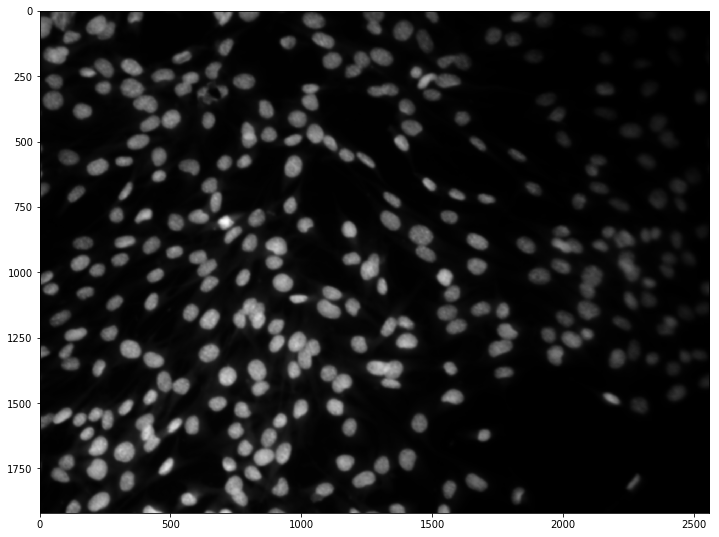

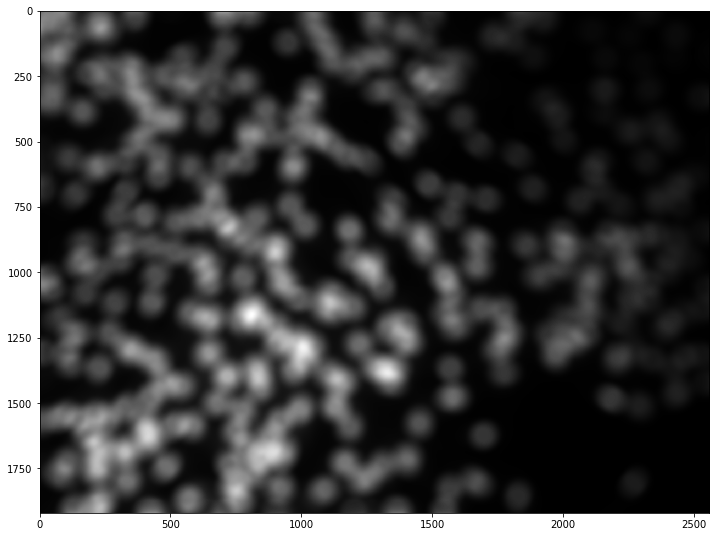

In [77]:
vis(Ni)
la = local_avg(Ni, short_th_radius)
vis(la)

started


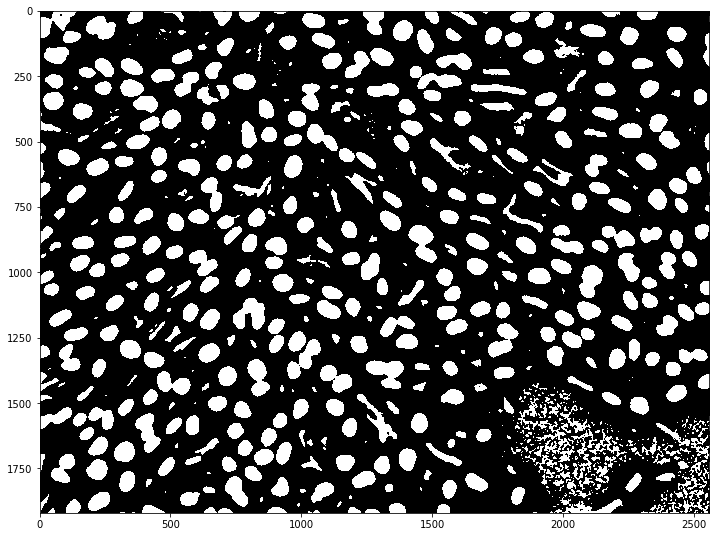

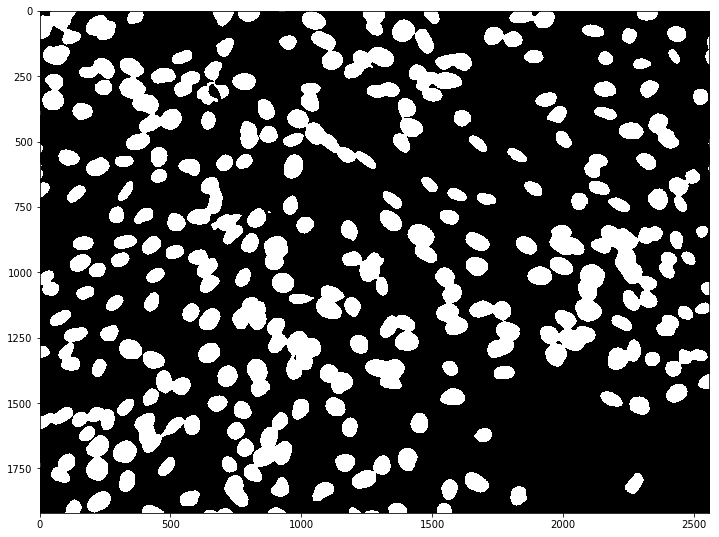

In [110]:
print('started')

# Step 3: short range local avg threshold
th_short = Ni > local_avg(Ni, short_th_radius)

vis(th_short)

# Step 4: long range local avg threshold
th_long = Ni > local_avg(Ni, long_th_radius)

vis(th_long)

# Step 5: long && short
th_Ni = (th_short*th_long)

In [79]:
np.allclose(th_Nc, th_Ni)

False

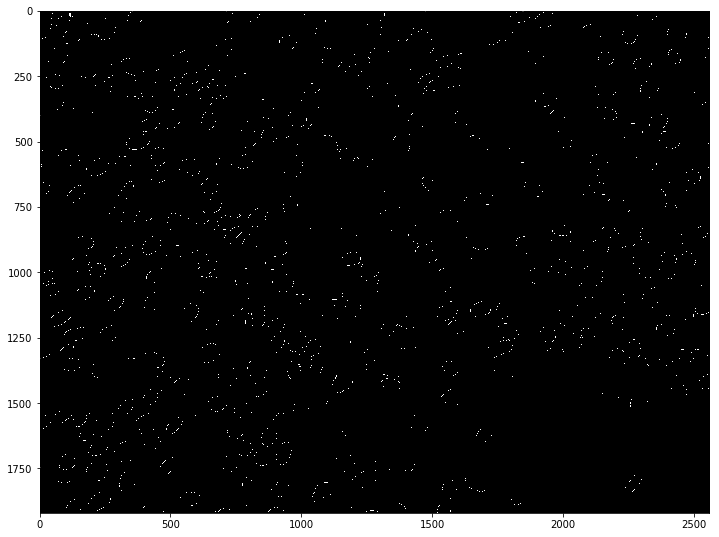

In [82]:
vis(th_Nc ^ th_Ni)

# Cells - Remove Small Objects

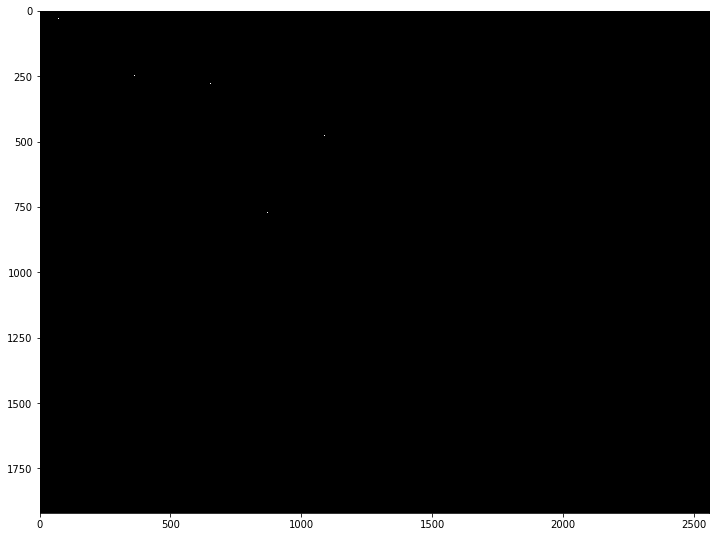

In [83]:
# Step 6: remove the short and long frequencies
freq_Nuc = sgmt.remove_freq(th_Nc, cutmax = max_frequency_to_remove, cutmin = min_frequency_to_remove)

# Step 7: threshold the inverse fourier transform
th_m = sgmt.th_freq_1(freq_Nuc)

vis(th_Nc ^ (freq_Nuc > th_m))

th_Nc = freq_Nuc > th_m
del freq_Nuc

# Step 8: remove small objects
th_Nc = sgmt.do_rem_obj(th_Nc, max_size_of_small_objects_to_remove * (zoomLev), 'less')[0]

# ImageMKS - Remove Small Objects

In [89]:
# Step 8: remove small objects
th_Ni = remove_small_objects(th_Ni, max_size_of_small_objects_to_remove * (zoomLev))

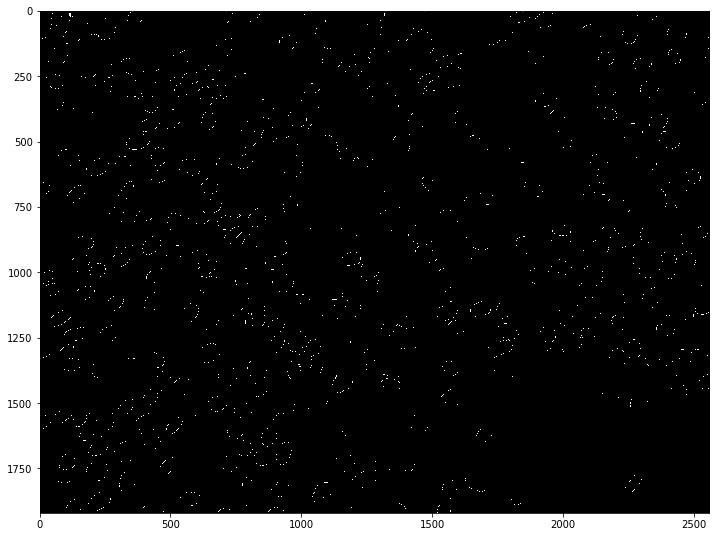

In [90]:
vis(th_Nc ^ th_Ni)

# Cells - Nucleus Watershed

In [91]:
def _gen_marks(label_img):
    props = regionprops(label_img)
    markers = np.zeros(label_img.shape)
    label_val = 1

    for i in props:
        x, y = i.centroid
        x = int(round(x))
        y = int(round(y))
        markers[x,y] = label_val
        label_val += 1

    return markers

In [95]:
# Step 9: distance transform
distance = ndi.distance_transform_edt(th_Nc)

# Step 10: mark the maxima in the distance transform and assign labels
peak_markers = corner_peaks(distance, min_distance=peak_min_distance, indices=False)
peak_markers = ndi.label(peak_markers)[0]

# Step 11: separate touching nuclei using the watershed markers
label_Nc = watershed(th_Nc, peak_markers, mask=th_Nc)

# Step 12: removing small regions after the watershed segmenation
sizes_matrix = ndi.sum(label_Nc>0, label_Nc, np.unique(label_Nc))
rem_region = sizes_matrix < ( size_after_watershed_to_remove * (zoomLev) )
remove_pixel = rem_region[label_Nc]
label_Nc[remove_pixel] = 0

# Step 13: reassigning labels, so that they are continuously numbered
old_labels = np.unique(label_Nc)
for i in range(len(old_labels)):
    label_Nc[label_Nc == old_labels[i]] = i

# ImageMKS - Nucleus Watershed

In [111]:
# Step 9: distance transform
distance = ndi.distance_transform_edt(th_Ni)

# Step 10: mark the maxima in the distance transform and assign labels
peak_markers = corner_peaks(distance, min_distance=peak_min_distance, indices=False)
peak_markers = ndi.label(peak_markers)[0]

# Step 11: separate touching nuclei using the watershed markers
label_Ni = watershed(th_Ni, peak_markers, mask=th_Ni)

# Step 12: removing small regions after the watershed segmenation
label_Ni = remove_small_objects(label_Ni, size_after_watershed_to_remove * (zoomLev))

# Step 13: reassigning labels, so that they are continuously numbered
old_labels = np.unique(label_Ni)
for i in range(len(old_labels)):
    label_Ni[label_Ni == old_labels[i]] = i

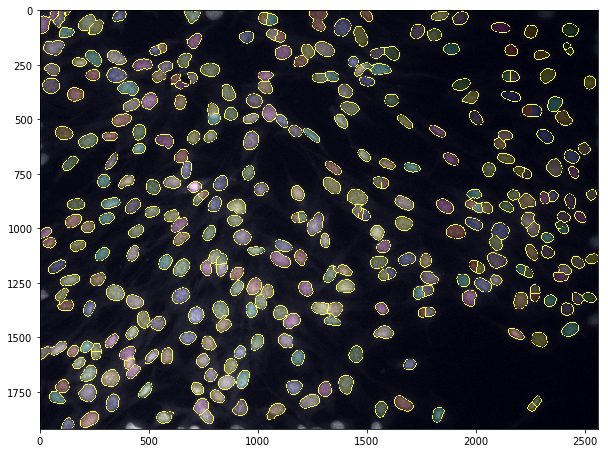

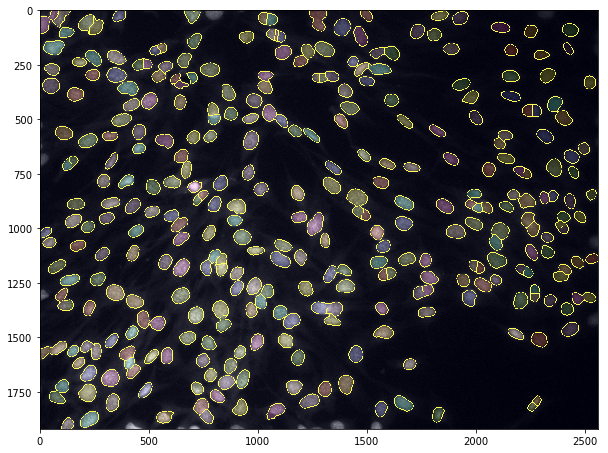

In [112]:
def labelvis(A, L, bg_color='b'):
    if bg_color is 'b':
        bg_color=(0.1,0.1,0.5)
    elif bg_color is 'c':
        bg_color=(0.1,0.5,0.1)
        
    A = label2rgb(L, A, bg_label=0, bg_color=bg_color, alpha=0.1, image_alpha=1)

    A = np.interp(A, (0,1), (0,255)).astype(np.uint8)

    A = make_boundary_image(L, A)

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(A)
    plt.show(fig)

labelvis(Nc_in, label_Nc)
labelvis(Nc_in, label_Ni)

# Cells - Cytoskeleton Segmentation

# ImageMKS - Cytoskeleton Segmentation

In [ ]:
# Step 14: local threshold of the cytoskeleton
th_Cyto = imgCyto > local_avg(imgCyto, cyto_local_avg_size)[0]

# Step 15: generate relabeled markers from the nuclei centroids
new_markers = _gen_marks(label_Nuc)

# Step 16: watershed of cytoskeleton using new_markers
label_Cyto = watershed(th_Cyto, new_markers, mask=th_Cyto.astype(np.bool_))